In [32]:
from solver import classic_solver
from aspen import aspen_solver
import partion
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
def model(u):
    return np.array([u**2+1, 2*max(u, 0)])

class Diffusion():
    def __init__(self, Nx, Amp=0, Period=0, Scale=1, model=None):
        self.val = np.zeros((Nx+1, 1))
        for i in range(Nx+1):
            self.val[i] = (
                Amp * np.sin(Period * 2*np.pi * (i+1) / (Nx+1)) + 1) * Scale
        self.model = model

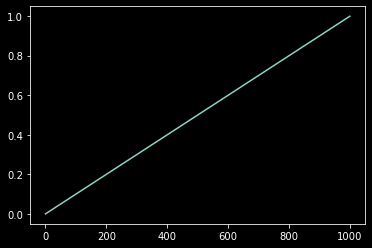

In [196]:
# inital condition

x0 = 1/1000*(np.arange(1000))
x0 = np.reshape(x0, (-1, 1))
plt.plot(x0)

In [197]:
Nx = 1000
Nt = 100
param = {
    'Nx': Nx, 
    'Nt': Nt,
}
D = Diffusion(Nx, 0.9, 1, 0.5e-1, model=model)
solver_cl = classic_solver(param, D)
solver_cl.setBoundary(0, 1)
solver_cl.x0 = np.copy(x0)
solver_cl.setSources([0.6], [0])

X_cl, code, message = solver_cl.solve()
print(X_cl, message)

[[0.         0.00101892 0.00115584 ... 0.00133488 0.00133162 0.        ]
 [0.001      0.00209822 0.0023141  ... 0.00265952 0.00265254 0.        ]
 [0.002      0.00317369 0.00346634 ... 0.00397677 0.00396609 0.        ]
 ...
 [0.997      0.99751746 0.99776191 ... 0.99932895 0.99932946 0.        ]
 [0.998      0.99834641 0.99851078 ... 0.99955391 0.99955424 0.        ]
 [0.999      0.99917033 0.99925501 ... 0.99977754 0.9997777  0.        ]] OK


In [202]:
Nx = 1000
Nt = 100
Nd = 4
param = {
    'Nx': Nx, 
    'Nt': Nt,
    'Nd': Nd
}
D = Diffusion(Nx, 0.9, 1, 0.5e-1, model=model)

part = partion.partion_equally
solver_as = aspen_solver(param, D, part)
solver_as.setBoundary(0, 1)
solver_as.x0 = np.copy(x0)
solver_as.setSources([0.6], [0])
X, code, message = solver_as.solve()
print(X, message)

[[0.         0.00107874 0.0011605  ... 0.00133328 0.00132955 0.        ]
 [0.001      0.00215536 0.00231983 ... 0.00265787 0.00265044 0.        ]
 [0.002      0.00322827 0.00347302 ... 0.00397508 0.00396396 0.        ]
 ...
 [0.997      0.99752712 0.99776723 ... 0.99932654 0.99932724 0.        ]
 [0.998      0.99835645 0.99851614 ... 0.99955236 0.99955282 0.        ]
 [0.999      0.99918078 0.9992604  ... 0.99977684 0.99977707 0.        ]] OK


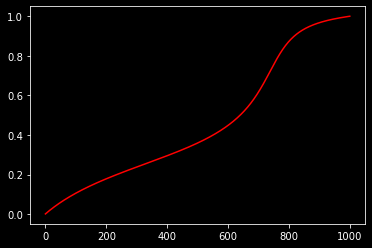

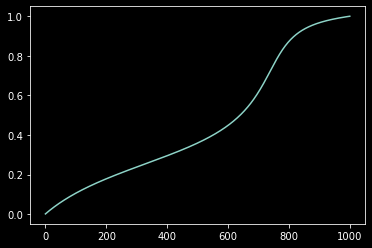

OK


In [203]:
step = 98
plt.style.use('dark_background')
plt.plot(X_cl[:, step], color = 'r')
plt.show()
plt.plot(X[:, step])
plt.show()
print(message)

In [204]:
print('aspen/newton comparsion')
print('---global versus newton---')
print('gb_resbld = {}, resbld ={}'.format(solver_as.timelog.gb_resbld, solver_cl.timelog.resbld))
print('gb_jacbld = {}, jacbld = {}'.format(solver_as.timelog.gb_jacbld, solver_cl.timelog.jacbld))
print('gb_linsol = {}, linsol = {}'.format(solver_as.timelog.gb_linsol, solver_cl.timelog.linsol))
print('---local+global time vs newton time---')
t1 = solver_as.timelog.gb_resbld+solver_as.timelog.gb_jacbld \
      +solver_as.timelog.gb_linsol+np.sum(solver_as.timelog.lc_resbld) \
      +np.sum(solver_as.timelog.lc_jacbld)+np.sum(solver_as.timelog.lc_linsol)
t2 = solver_cl.timelog.resbld+solver_cl.timelog.jacbld \
      +solver_cl.timelog.linsol
print('aspen = {}, newton = {}'.format(t1, t2))

aspen/newton comparsion
---global versus newton---
gb_resbld = 7.147303581237793, resbld =3.894019842147827
gb_jacbld = 10.156515121459961, jacbld = 4.757405757904053
gb_linsol = 3.941032648086548, linsol = 1.773362636566162
---local+global time vs newton time---
aspen = 35.43264365196228, newton = 10.424788236618042


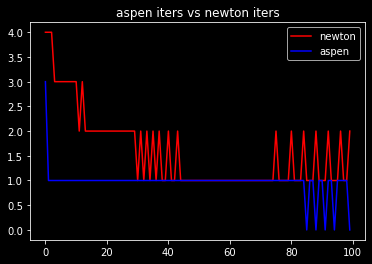

In [208]:
plt.title('aspen iters vs newton iters')
plt.plot(solver_cl.timelog.kn, color = 'r', label='newton')
plt.plot(solver_as.timelog.aspen_iters, color = 'b', label='aspen')
plt.legend()
plt.show()

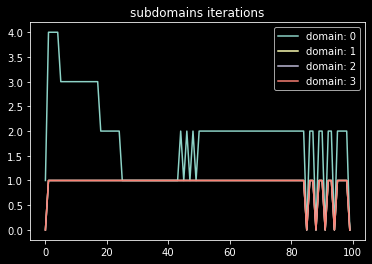

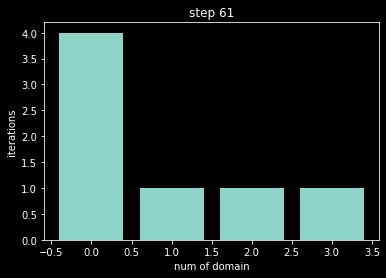

In [207]:
plt.title('subdomains iterations')

for i in range(Nd):
    plt.plot(solver_as.timelog.domain_iters[:, i], label='domain: {}'.format(i))
    
plt.legend()
plt.show()

plt.title('step 61')
plt.xlabel('num of domain')
plt.ylabel('iterations')
plt.bar(np.arange(0, Nd, 1, dtype='int'), solver_as.timelog.domain_iters[1, :])
plt.show()

In [188]:
print('subdomain time')
print('---resbld---')
print(solver_as.timelog.lc_resbld)
print('---jacbld---')
print(solver_as.timelog.lc_jacbld)
print('---linsol---')
print(solver_as.timelog.lc_linsol)

subdomain time
---resbld---
[2.81210756 1.85190582 1.82384872 1.79110742]
---jacbld---
[3.09602189 1.16047788 1.14335465 1.04004741]
---linsol---
[0.20711374 0.07654786 0.07321858 0.06799507]
